In [1]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle
from jax.tree_util import tree_map

from jax import jit,vmap
import pandas as pd
import blackjax

import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline
import gm_glm_bayesian as glm

In [2]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']

In [3]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = 0

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


regressors=glm.get_regressors(fr)
target = fr[unit_str].values
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


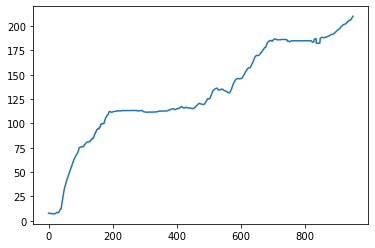

In [4]:
inds = slice(250,1200)
regressors_sim = {'trial_inds_int':regressors['trial_inds_int'][inds],'position':regressors['position'][inds],'dt':regressors['dt']}
plt.plot(regressors_sim['position'])

In [5]:
import gm_glm_bayesian_helper as glmh

In [6]:
trial_len = len(regressors_sim['position'])

In [9]:
# generate multiple trials using the same param
ntrials = 20
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
pars_sim = {'logws':np.array([[50.,90.]]),'mus':np.array([[30,90]]),'logb':np.array([1.]),'logsigmas':np.array([[5.,5.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=glmh.duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)
target_spk = numpy.random.poisson(target_rate)



In [22]:
# regressors_sim_dup['trial_inds_int'] = np.repeat(np.arange(ntrials),trial_len)

# step 1: change the parameterization of the gmm

CPU times: user 8.09 s, sys: 979 ms, total: 9.07 s
Wall time: 9.36 s


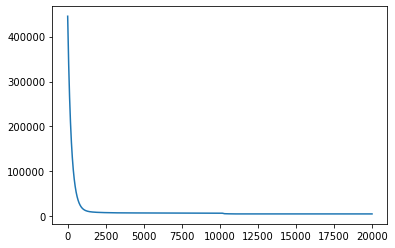

In [46]:
%%time
# if only use gd

### trial average
# pars_sim_init = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=1.)
# regressors_sim_dup=glmh.duplicate_dict(regressors_sim,N=ntrials)

### single trial
pars_sim_init = gm.init_all_trials(ntrials=ntrials,random_init=True,sigma_default=1.)
regressors_sim_dup['trial_inds_int'] = np.repeat(np.arange(ntrials),trial_len)


niters=20000
lr=5e-2
reg_pars = gm.get_reg_pars({'g_mu':0.1,'g_sigma':0.1,'g_w':10,'g_b':0.1})
regressors_ = regressors_sim_dup
pars_sim_init = glm.get_parbar(pars_sim_init)
pars_fit_gd,loss_l=gm.train_adam(glm.negative_logpdf,regressors_,pars_sim_init,target_spk,reg_pars=reg_pars,reg_type='gaussian_logprior_laplacian',loss_type='poisson',niters=niters,lr=lr)

plt.plot(loss_l)

In [47]:
pars_fit_gd

{'b_bar': DeviceArray(1.4852326, dtype=float32),
 'logb': DeviceArray([1.3016573 , 1.2237046 , 0.92886096, 1.053717  , 0.9390216 ,
              0.8625438 , 0.91745496, 0.93555224, 0.99046063, 0.84858954,
              0.87134224, 0.7775304 , 0.64388394, 0.27946144, 0.4538209 ,
              0.8235155 , 1.0013504 , 0.83858365, 1.0865151 , 1.1503215 ],            dtype=float32),
 'logsigmas': DeviceArray([[4.8779354, 4.883751 ],
              [4.8637   , 4.8460536],
              [4.8246827, 4.7511525],
              [4.65834  , 4.7414465],
              [4.8695297, 4.6776867],
              [4.9136567, 4.69441  ],
              [4.8907776, 4.692142 ],
              [4.8483334, 4.8326716],
              [4.9562774, 5.032749 ],
              [4.751181 , 5.0782547],
              [4.739313 , 5.2974443],
              [4.8026524, 5.283409 ],
              [4.6840487, 5.192549 ],
              [4.596308 , 5.1521177],
              [4.7317934, 5.035966 ],
              [4.878421 , 5.056808 ]

In [26]:
pars_sim

{'logws': DeviceArray([[60., 80.]], dtype=float32),
 'mus': DeviceArray([[30, 90]], dtype=int32),
 'logb': DeviceArray([1.], dtype=float32),
 'logsigmas': DeviceArray([[5., 5.]], dtype=float32)}

<AxesSubplot:xlabel='position_bin'>

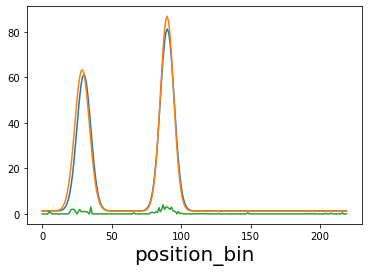

In [43]:
ys_l=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_sim)

plt.plot(np.squeeze(ys_l))

ys_l_hat=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_fit_gd)

plt.plot(ys_l_hat[:,10])

df = glmh.get_df(regressors_sim_dup,target_rate=target_rate,target_spk=target_spk)

df.query('trial_inds_int==3').groupby('position_bin').mean()['target_spk'].plot()

# step 2 changing parameters

In [10]:


import math_functions as mf
reload(mf)
L = mf.get_modified_laplacian_matrix(ntrials) 
Lcov = np.linalg.inv(L)
from math_functions import softplus

In [57]:
reg_pars

{'S_l1': 100000000.0,
 'g_mu': 0.1,
 'g_sigma': 0.1,
 'g_w': 10,
 'g_b': 0.1,
 'sigma_thresh': 1,
 'g_sigma_thresh': 1000.0,
 'nfields': 2}

In [112]:
pars_sim_np = {}
for k,v in pars_sim.items():
    pars_sim_np[k]=numpy.array(v)

In [11]:

Lcov = mf.get_modified_laplacian_matrix(ntrials,inv=True) 


def add_noise_par(par,Lcov,reg_pars,log_names=['sigma','b','w'],nolog_names=['mu']):
    par_copy = {}
    ntrials = Lcov.shape[0]
    for n in log_names:
        if n!='b':
            name_in_par = f'log{n}s'
            nfields = par[name_in_par].shape[1]
            par_copy[name_in_par] = numpy.zeros((ntrials,nfields))
            for k in range(nfields):
                noise = scipy.stats.multivariate_normal.rvs(cov=Lcov,size=1) * numpy.sqrt(reg_pars[f'g_{n}'])
                par_copy[name_in_par][:,k] = par[name_in_par][:,k] + noise 
        else:
            name_in_par = 'logb'
            par_copy[name_in_par] = numpy.zeros(ntrials)
            noise = scipy.stats.multivariate_normal.rvs(cov=Lcov,size=1) * numpy.sqrt(reg_pars[f'g_{n}'])
            par_copy[name_in_par] = par[name_in_par] + noise 
    for n in nolog_names:
        name_in_par = f'{n}s'
        nfields= par[name_in_par].shape[1]
        par_copy[name_in_par] = numpy.zeros((ntrials,nfields))
        for k in range(nfields):
            noise = scipy.stats.multivariate_normal.rvs(cov=Lcov,size=1) * numpy.sqrt(reg_pars[f'g_{n}'])
            par_copy[name_in_par][:,k] = par[name_in_par][:,k] + noise 
    return par_copy
                
    

In [173]:
reg_pars = gm.get_reg_pars({'g_mu':0.1,'g_sigma':0.1,'g_w':100,'g_b':0.1})
pars_sim_noise_trial = add_noise_par(pars_sim_np,Lcov,reg_pars)

regressors_sim_dup=glmh.duplicate_dict(regressors_sim,N=ntrials)
regressors_sim_dup['trial_inds_int'] = np.repeat(np.arange(ntrials),trial_len)

target_rate = glm.forward(regressors_sim_dup,pars_sim_noise_trial)
target_spk = numpy.random.poisson(target_rate)



In [192]:
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

CPU times: user 7.66 s, sys: 1 s, total: 8.66 s
Wall time: 8.9 s


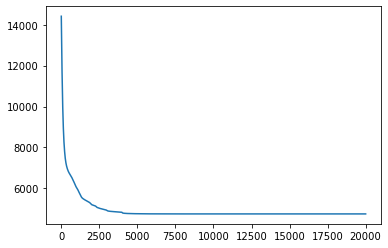

In [193]:
%%time
# if only use gd

### trial average
# pars_sim_init = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=1.)
# regressors_sim_dup=glmh.duplicate_dict(regressors_sim,N=ntrials)

### single trial
pars_sim_init = gm.init_all_trials(ntrials=ntrials,random_init=True,sigma_default=1.)
# regressors_sim_dup['trial_inds_int'] = np.repeat(np.arange(ntrials),trial_len)


niters=20000
lr=5e-2

regressors_ = regressors_sim_dup
reg_type=None
pars_sim_init = glm.get_parbar(pars_sim_init)
pars_fit_gd,loss_l=gm.train_adam(glm.negative_logpdf,regressors_,pars_sim_init,target_spk,reg_pars=reg_pars,reg_type=reg_type,loss_type='poisson',niters=niters,lr=lr)


plt.plot(loss_l)

In [191]:
pars_fit_gd_reg = copy.copy(pars_fit_gd)

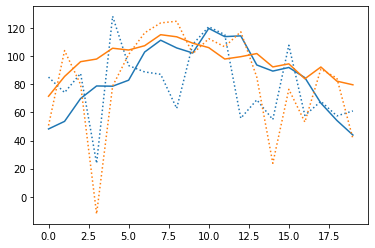

In [194]:
for i in range(pars_fit_gd['logws'].shape[1]):
    plt.plot(pars_fit_gd['logws'][:,i],color=f'C{i}',linestyle=':')
    plt.plot(pars_sim_noise_trial['logws'][:,i],color=f'C{i}',linestyle='-')

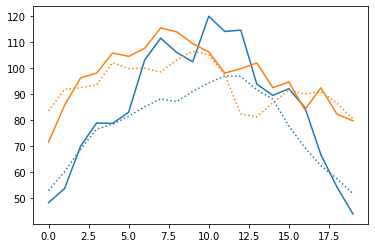

In [181]:
for i in range(pars_fit_gd['logws'].shape[1]):
    plt.plot(pars_fit_gd['logws'][:,i],color=f'C{i}',linestyle=':')
    plt.plot(pars_sim_noise_trial['logws'][:,i],color=f'C{i}',linestyle='-')

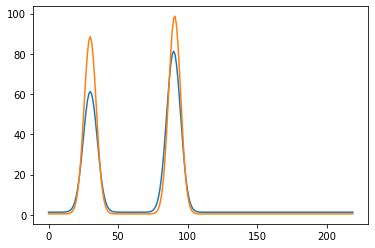

In [199]:
ys_l=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_sim)

plt.plot(np.squeeze(ys_l))

ys_l_hat_reg=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_fit_gd_reg)

plt.plot(ys_l_hat_reg[:,7])

df = glmh.get_df(regressors_sim_dup,target_rate=target_rate,target_spk=target_spk)

# df.query('trial_inds_int==3').groupby('position_bin').mean()['target_spk'].plot()

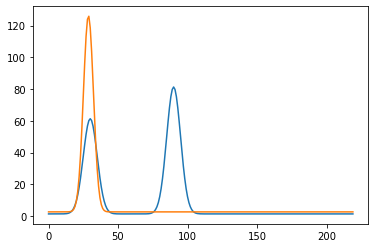

In [200]:
ys_l=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_sim)

plt.plot(np.squeeze(ys_l))

ys_l_hat=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_fit_gd)

plt.plot(ys_l_hat[:,7])

df = glmh.get_df(regressors_sim_dup,target_rate=target_rate,target_spk=target_spk)

# df.query('trial_inds_int==3').groupby('position_bin').mean()['target_spk'].plot()

# a more difficult case

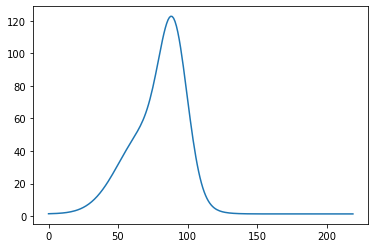

In [18]:


# generate multiple trials using the same param
ntrials = 20
# pars_sim = gm.init_all_trials(ntrials=1,random_init=True,sigma_default=10)
pars_sim = {'logws':np.array([[50.,90.]]),'mus':np.array([[70,90]]),'logb':np.array([1.]),'logsigmas':np.array([[20.,10.]])}
# pars_sim = duplicate_dict(pars_sim,(ntrials,1))
regressors_sim_dup=glmh.duplicate_dict(regressors_sim,N=ntrials)

target_rate = glm.forward(regressors_sim_dup,pars_sim)
target_spk = numpy.random.poisson(target_rate)

ys_l=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_sim)

plt.plot(np.squeeze(ys_l))


{'b_bar': DeviceArray(1.4760338, dtype=float32), 'logb': DeviceArray([1.2862576 , 1.5337244 , 0.6193056 , 0.97756207, 0.62662387,
             0.61495876, 0.5784051 , 1.0941993 , 0.63295186, 0.75340134,
             0.6791658 , 1.5377539 , 1.563943  , 1.4740158 , 0.26498306,
             0.91017747, 1.2516658 , 1.1092726 , 0.853527  , 1.1444254 ],            dtype=float32), 'logsigmas': DeviceArray([[10.090423, 20.657564],
             [ 9.91936 , 20.735825],
             [ 9.937772, 20.825481],
             [ 9.981251, 20.874023],
             [10.189938, 20.833805],
             [10.329419, 20.734905],
             [10.289004, 20.604458],
             [10.391481, 20.595694],
             [10.375038, 20.566713],
             [10.41788 , 20.63495 ],
             [10.429929, 20.618595],
             [10.495058, 20.593231],
             [10.360886, 20.56068 ],
             [10.197886, 20.518179],
             [10.023901, 20.445105],
             [ 9.907506, 20.43124 ],
             [ 9.9

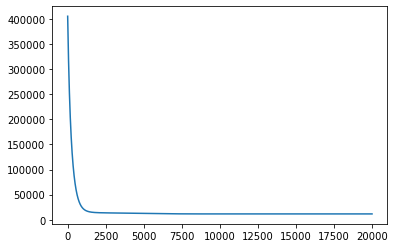

In [19]:
%%time
# if only use gd

### single trial
pars_sim_init = gm.init_all_trials(ntrials=ntrials,random_init=True,sigma_default=1.,K=2)
regressors_sim_dup['trial_inds_int'] = np.repeat(np.arange(ntrials),trial_len)


niters=20000
lr=5e-2
reg_pars = gm.get_reg_pars({'g_mu':0.1,'g_sigma':0.1,'g_w':10,'g_b':10})
regressors_ = regressors_sim_dup
pars_sim_init = glm.get_parbar(pars_sim_init)
pars_fit_gd,loss_l=gm.train_adam(glm.negative_logpdf,regressors_,pars_sim_init,target_spk,reg_pars=reg_pars,reg_type='gaussian_logprior_laplacian',loss_type='poisson',niters=niters,lr=lr)

plt.plot(loss_l)
print(pars_fit_gd)

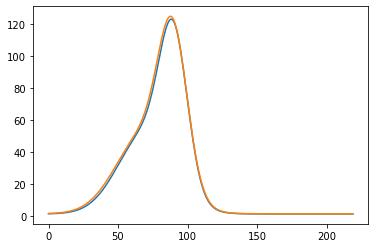

In [20]:
ys_l=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_sim)

plt.plot(np.squeeze(ys_l))

ys_l_hat=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_fit_gd)

plt.plot(ys_l_hat[:,7])

df = glmh.get_df(regressors_sim_dup,target_rate=target_rate,target_spk=target_spk)

# df.query('trial_inds_int==3').groupby('position_bin').mean()['target_spk'].plot()

In [21]:
glm.negative_logpdf_no_reg(regressors_,pars_fit_gd,target_spk)

DeviceArray(11561.91, dtype=float32)

# difficult case + drift in ground truth parameters

In [37]:
reload(mf)
Lcov = mf.get_modified_laplacian_matrix(ntrials,inv=True)
reg_pars = gm.get_reg_pars({'g_mu':0.1,'g_sigma':0.1,'g_w':100,'g_b':0.1})
pars_sim_noise_trial = add_noise_par(pars_sim,Lcov,reg_pars)

target_rate = glm.forward(regressors_sim_dup,pars_sim_noise_trial)
target_spk = numpy.random.poisson(target_rate)


{'b_bar': DeviceArray(1.5723714, dtype=float32), 'logb': DeviceArray([1.3319651, 1.0687209, 0.9926757, 1.0245924, 1.2598329,
             1.0006611, 0.994765 , 1.1756265, 1.1406922, 0.9731925,
             1.1089233, 1.4199666, 1.3188075, 1.3514405, 1.0098954,
             1.1953423, 1.6178389, 1.4648339, 1.1662552, 1.3478287],            dtype=float32), 'logsigmas': DeviceArray([[ 9.193472 , 20.400688 ],
             [ 9.232547 , 20.39456  ],
             [ 9.276722 , 20.389029 ],
             [ 9.390002 , 20.565994 ],
             [ 9.395412 , 20.73294  ],
             [ 9.400452 , 20.88071  ],
             [ 9.503607 , 21.06285  ],
             [ 9.762256 , 21.346367 ],
             [ 9.933674 , 21.494347 ],
             [10.097193 , 21.71515  ],
             [10.128553 , 21.75656  ],
             [10.15805  , 21.677694 ],
             [10.07791  , 21.489897 ],
             [ 9.914341 , 21.243574 ],
             [ 9.773382 , 21.093157 ],
             [ 9.671069 , 20.923342 ],
      

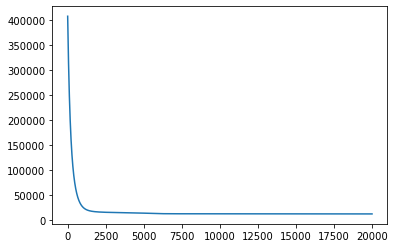

In [40]:
%%time


pars_sim_init = gm.init_all_trials(ntrials=ntrials,random_init=True,sigma_default=1.,K=2)
regressors_sim_dup['trial_inds_int'] = np.repeat(np.arange(ntrials),trial_len)


niters=20000
lr=5e-2
# reg_pars = gm.get_reg_pars({'g_mu':0.1,'g_sigma':0.1,'g_w':10,'g_b':10})
regressors_ = regressors_sim_dup
pars_sim_init = glm.get_parbar(pars_sim_init)
pars_fit_gd,loss_l=gm.train_adam(glm.negative_logpdf,regressors_,pars_sim_init,target_spk,reg_pars=reg_pars,reg_type='gaussian_logprior_laplacian',loss_type='poisson',niters=niters,lr=lr)

plt.plot(loss_l)
print(pars_fit_gd)


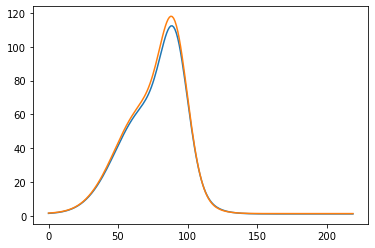

In [55]:
tt=14
ys_l=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_sim_noise_trial)

plt.plot(np.squeeze(ys_l[:,tt]))

ys_l_hat=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_fit_gd)

plt.plot(ys_l_hat[:,tt])

df = glmh.get_df(regressors_sim_dup,target_rate=target_rate,target_spk=target_spk)

# df.query('trial_inds_int==3').groupby('position_bin').mean()['target_spk'].plot()

In [61]:
reload(glmh)

<module 'gm_glm_bayesian_helper' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian_helper.py'>

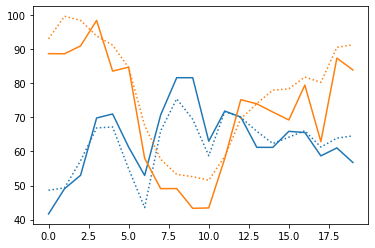

In [62]:
pars_fit_gd = glmh.reorder(pars_fit_gd)
for i in range(pars_fit_gd['logws'].shape[1]):
    plt.plot(pars_fit_gd['logws'][:,i],color=f'C{i}',linestyle=':')
    plt.plot(pars_sim_noise_trial['logws'][:,i],color=f'C{i}',linestyle='-')

# MCMC!!!

In [105]:
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [119]:
K = 2
Nchains = 10
key = jax.random.PRNGKey(1)
key_l = jax.random.split(key,num=Nchains)
pars_sim_init_multi=jax.vmap(glm.random_init_jax,in_axes=(0,None,None))(key_l,ntrials,K)

In [120]:
%%time
states = glm.fit_multichain(regressors_,pars_sim_init_multi,target_spk, sampler_kw={'step_size':1e-2},num_samples=5000,rng_key_int=0)



CPU times: user 4.98 s, sys: 950 ms, total: 5.93 s
Wall time: 7.38 s


In [121]:
samples = states.position
logprob=states.logprob

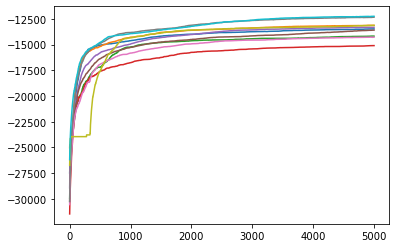

In [125]:
plt.plot(logprob)

## fit with an incorrect N field

{'b_bar': DeviceArray(1.5136411, dtype=float32), 'logb': DeviceArray([1.3060714 , 1.672609  , 0.7800553 , 1.3608268 , 0.950467  ,
             0.74561304, 0.7061363 , 1.1296561 , 0.6118168 , 0.8808525 ,
             0.88412476, 1.6498953 , 1.6550028 , 1.587241  , 0.31574026,
             1.084718  , 1.4225727 , 1.2133598 , 0.97590035, 1.2225993 ],            dtype=float32), 'logsigmas': DeviceArray([[16.058413],
             [16.009174],
             [16.08142 ],
             [16.193527],
             [16.190857],
             [16.160107],
             [15.999505],
             [16.163586],
             [16.163485],
             [16.253906],
             [16.224817],
             [16.24143 ],
             [16.24213 ],
             [16.220758],
             [15.964615],
             [15.807507],
             [15.654507],
             [15.740887],
             [15.746902],
             [15.859269]], dtype=float32), 'logws': DeviceArray([[108.46157 ],
             [108.91084 ],
          

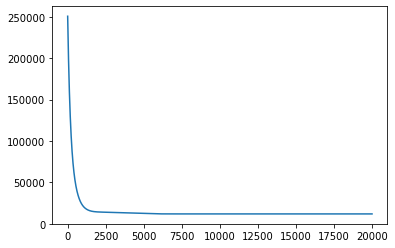

In [23]:
%%time
K = 1
pars_sim_init = gm.init_all_trials(ntrials=ntrials,random_init=True,sigma_default=1.,K=K)
regressors_sim_dup['trial_inds_int'] = np.repeat(np.arange(ntrials),trial_len)


niters=20000
lr=5e-2
reg_pars = gm.get_reg_pars({'g_mu':0.1,'g_sigma':0.1,'g_w':10,'g_b':10})
regressors_ = regressors_sim_dup
pars_sim_init = glm.get_parbar(pars_sim_init)
pars_fit_gd,loss_l=gm.train_adam(glm.negative_logpdf,regressors_,pars_sim_init,target_spk,reg_pars=reg_pars,reg_type='gaussian_logprior_laplacian',loss_type='poisson',niters=niters,lr=lr)

plt.plot(loss_l)
print(pars_fit_gd)

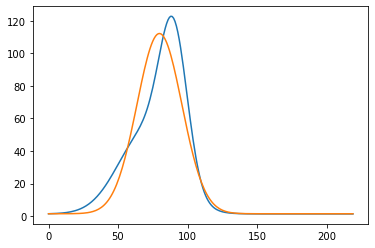

In [26]:
ys_l=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_sim)

plt.plot(np.squeeze(ys_l))

ys_l_hat=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_fit_gd)

plt.plot(ys_l_hat[:,7])

df = glmh.get_df(regressors_sim_dup,target_rate=target_rate,target_spk=target_spk)

# df.query('trial_inds_int==3').groupby('position_bin').mean()['target_spk'].plot()

In [25]:
glm.negative_logpdf_no_reg(regressors_,pars_fit_gd,target_spk)

DeviceArray(11873.066, dtype=float32)

{'b_bar': DeviceArray(1.4943908, dtype=float32), 'logb': DeviceArray([1.3086371 , 1.5290321 , 0.6451081 , 0.8878403 , 0.40473026,
             0.5956606 , 0.5582027 , 1.1103177 , 0.6443499 , 0.7252355 ,
             0.6224265 , 1.4954498 , 1.5829531 , 1.487325  , 0.2811063 ,
             0.8868253 , 1.0780785 , 1.022316  , 0.75115484, 1.1697547 ],            dtype=float32), 'logsigmas': DeviceArray([[33.28122  , 20.047766 ,  9.963424 ],
             [33.27665  , 20.109093 ,  9.798292 ],
             [33.276443 , 20.177572 ,  9.824207 ],
             [33.271275 , 20.183674 ,  9.874709 ],
             [33.275677 , 20.128782 , 10.087035 ],
             [33.274574 , 20.071182 , 10.21596  ],
             [33.279377 , 19.97862  , 10.162255 ],
             [33.277462 , 20.021526 , 10.250924 ],
             [33.28226  , 20.016539 , 10.225839 ],
             [33.28048  , 20.09801  , 10.265187 ],
             [33.28462  , 20.086134 , 10.272956 ],
             [33.282974 , 20.078527 , 10.33684  ]

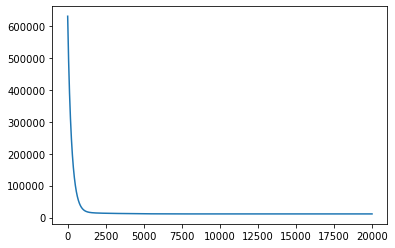

In [27]:
%%time
K = 3
pars_sim_init = gm.init_all_trials(ntrials=ntrials,random_init=True,sigma_default=1.,K=K)
regressors_sim_dup['trial_inds_int'] = np.repeat(np.arange(ntrials),trial_len)


niters=20000
lr=5e-2
reg_pars = gm.get_reg_pars({'g_mu':0.1,'g_sigma':0.1,'g_w':10,'g_b':10})
regressors_ = regressors_sim_dup
pars_sim_init = glm.get_parbar(pars_sim_init)
pars_fit_gd,loss_l=gm.train_adam(glm.negative_logpdf,regressors_,pars_sim_init,target_spk,reg_pars=reg_pars,reg_type='gaussian_logprior_laplacian',loss_type='poisson',niters=niters,lr=lr)

plt.plot(loss_l)
print(pars_fit_gd)

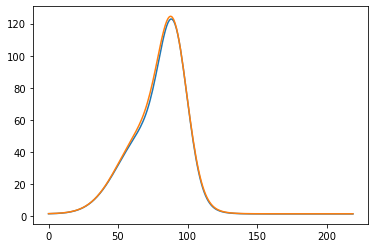

In [28]:
ys_l=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_sim)

plt.plot(np.squeeze(ys_l))

ys_l_hat=gm.gm_func_by_trial(gm.get_regressor({'xs':np.arange(220)}),pars_fit_gd)

plt.plot(ys_l_hat[:,7])

df = glmh.get_df(regressors_sim_dup,target_rate=target_rate,target_spk=target_spk)

# df.query('trial_inds_int==3').groupby('position_bin').mean()['target_spk'].plot()

In [29]:
glm.negative_logpdf_no_reg(regressors_,pars_fit_gd,target_spk)

DeviceArray(11554.958, dtype=float32)